## NLP Classification

### Importing Libraries

In [43]:
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd
import pickle
from pprint import pprint
import swifter
import numpy as np
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
import re, string
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, train_test_split
import nltk
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [2]:
def plot_confusion_matrix(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

### Loading the Data Set

In [3]:
# load data
df_normalnews = pd.read_csv(r"data\stock_news.csv", encoding='latin-1')[["title"]]
df_normalnews = df_normalnews.rename(columns={"title":"text"})
df_fraudnews = pd.read_csv(r"data\fraud_news.csv").iloc[:,1:]
df_normalnews = df_normalnews.sample(5*len(df_fraudnews))
# merge
df_news = pd.concat([df_fraudnews, df_normalnews])
df_news = df_news.sample(frac=1).reset_index(drop=True)
df_news["target"] = df_news["target"].fillna(0)

### Text Pre-Processing

In [4]:
def preprocess(text):
    text = text.lower() 
    text = text.strip()
    text = text.replace("\r", " ").replace("\n", " ")
    text = re.sub('[^a-zA-Z]', ' ', text) # keep only alphabet characters
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) # adjust white space
    return text

In [5]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [6]:
wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [8]:
def text_process(string):
    return lemmatizer(stopword(preprocess(string)))

In [9]:
df_news['clean_text'] = df_news['text'].swifter.apply(lambda x: text_process(x))

Pandas Apply:   0%|          | 0/7914 [00:00<?, ?it/s]

In [10]:
df_news.to_csv(r'data\upgraded_database.csv')

### Vectorization 

In [11]:
# building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self
    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

#### Train Word2Vec

In [12]:
df_news['clean_text_tok']=[nltk.word_tokenize(i) for i in df_news['clean_text']]
# fit w2v
model = gensim.models.Word2Vec(df_news['clean_text_tok'], vector_size=300, window=8, min_count=1, sg=1, epochs=30)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
# w2v = gensim_api.load("word2vec-google-news-300")
modelw = MeanEmbeddingVectorizer(w2v)

Save model

In [13]:
pickle.dump(modelw, open("buffer\word2vec.pkl", "wb"))

#### Apply model to train data

In [14]:
X, y = df_news["clean_text"], df_news["target"]

In [15]:
# Word2Vec runs on tokenized sentences
X_tok = [nltk.word_tokenize(i) for i in X]  
# converting text to numerical data using Word2Vec
X_vectors_w2v = modelw.transform(X_tok)

Under-sampling: as the data set is quite small, we will use the SMOTE-Tomek Links method

In [16]:
smote_tomek  = SMOTETomek()
x_rspl, y_rspl = smote_tomek.fit_resample(X_vectors_w2v, y)

Split the training dataset into train and test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x_rspl, y_rspl, test_size=0.2, shuffle=True)

### ML Algorithms

In [18]:
df_summary = pd.DataFrame(columns=["Model", "Training Accuracy", "Accuracy", "AUC", "F1 Score", "Miss Rate"])

#### Support Vector Machine

Grid Search Cross Validation

In [19]:
C = [.0001, .001, .01]
gamma = [.0001, .001, .01, .1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear', 'rbf', 'poly']
probability = [True]
param_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

svc = SVC(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
gs_svc = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=False)

gs_svc.fit(X_train, y_train)

print("The best hyperparameters from Grid Search are:")
pprint(gs_svc.best_params_)
print("")
print(f"The mean accuracy of a model with these hyperparameters is: {np.round(gs_svc.best_score_,4)}")

The best hyperparameters from Grid Search are:
{'C': 0.0001, 'degree': 2, 'gamma': 100, 'kernel': 'poly', 'probability': True}

The mean accuracy of a model with these hyperparameters is: 0.9868


Experiment Model

In [20]:
best_svc = gs_svc.best_estimator_
best_svc.fit(X_train, y_train)
y_predict = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)[:,1]

Performance

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
cf_matrix = confusion_matrix(y_test, y_predict)
FNR = 1 - recall_score(y_test, y_predict)
d = {
    "Model":"SVM",
    "Training Accuracy":accuracy_score(y_train, best_svc.predict(X_train)),
    "Accuracy":accuracy_score(y_test, y_predict),
    "AUC":roc_auc,
    "F1 Score":f1_score(y_test, y_predict),
    "Miss Rate":FNR
}
df_summary = df_summary.append(d, ignore_index=True)
pprint(d)

{'AUC': 0.999250387309471,
 'Accuracy': 0.9901440485216073,
 'F1 Score': 0.990327380952381,
 'Miss Rate': 0.0015003750937734317,
 'Model': 'SVM',
 'Training Accuracy': 0.9991470811220622}



Classification Report 

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1305
         1.0       0.98      1.00      0.99      1333

    accuracy                           0.99      2638
   macro avg       0.99      0.99      0.99      2638
weighted avg       0.99      0.99      0.99      2638


Test Confusion Matrix


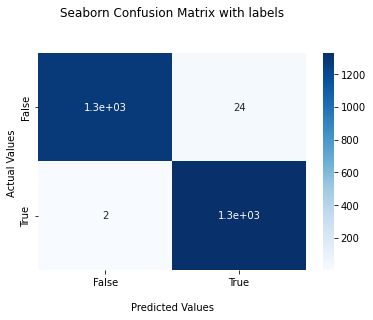

In [22]:
print("\nClassification Report \n")
print(classification_report(y_test,y_predict))
print("\nTest Confusion Matrix")
plot_confusion_matrix(cf_matrix)

#### Tree-Based Model

Grid Search Cross Validation

In [23]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgc = xgb.XGBClassifier(objective='binary:logistic',booster='gbtree',eval_metric='auc',tree_method='hist',grow_policy='lossguide',use_label_encoder=False)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
gs_xgb = GridSearchCV(estimator=xgc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=False)

gs_xgb.fit(X_train, y_train)

print("The best hyperparameters from Grid Search are:")
pprint(gs_xgb.best_params_)
print("")
print(f"The mean accuracy of a model with these hyperparameters is: {np.round(gs_xgb.best_score_,4)}")

The best hyperparameters from Grid Search are:
{'colsample_bytree': 0.8,
 'gamma': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

The mean accuracy of a model with these hyperparameters is: 0.9857


Experiment Model

In [24]:
best_xgb = gs_xgb.best_estimator_
best_xgb.fit(X_train, y_train)
y_predict = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:,1]

Performance

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
cf_matrix = confusion_matrix(y_test, y_predict)
FNR = 1 - recall_score(y_test, y_predict)
d = {
    "Model":"XGB",
    "Training Accuracy":accuracy_score(y_train, best_xgb.predict(X_train)),
    "Accuracy":accuracy_score(y_test, y_predict),
    "AUC":roc_auc,
    "F1 Score":f1_score(y_test, y_predict),
    "Miss Rate":FNR
}
df_summary = df_summary.append(d, ignore_index=True)
pprint(d)

{'AUC': 0.9989043237820949,
 'Accuracy': 0.988248673237301,
 'F1 Score': 0.9884629698548567,
 'Miss Rate': 0.0037509377344335793,
 'Model': 'XGB',
 'Training Accuracy': 1.0}



Classification Report 

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1305
         1.0       0.98      1.00      0.99      1333

    accuracy                           0.99      2638
   macro avg       0.99      0.99      0.99      2638
weighted avg       0.99      0.99      0.99      2638


Test Confusion Matrix


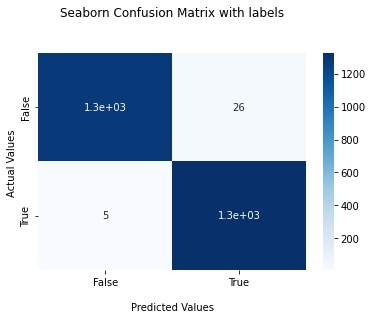

In [26]:
print("\nClassification Report \n")
print(classification_report(y_test,y_predict))
print("\nTest Confusion Matrix")
plot_confusion_matrix(cf_matrix)

#### Linear

Grid Search Cross Validation

In [27]:
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
multi_class = ['ovr']
solver = ['lbfgs','newton-cg','liblinear','sag','saga']
class_weight = ['balanced', None]
penalty = ['l1', 'l2', 'elasticnet', 'none']
param_grid = {
    'C': C,
    'multi_class': multi_class,
    'solver': solver,
    'class_weight': class_weight,
    'penalty': penalty,
    'max_iter' : [100, 1000,2500, 5000],
}

lrc = LogisticRegression(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
gs_log = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=False)

gs_log.fit(X_train, y_train)

print("The best hyperparameters from Grid Search are:")
pprint(gs_log.best_params_)
print("")
print(f"The mean accuracy of a model with these hyperparameters is: {np.round(gs_log.best_score_,4)}")

The best hyperparameters from Grid Search are:
{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 5000,
 'multi_class': 'ovr',
 'penalty': 'none',
 'solver': 'saga'}

The mean accuracy of a model with these hyperparameters is: 0.9795


Experiment Model

In [28]:
best_log = gs_log.best_estimator_
best_log.fit(X_train, y_train)
y_predict = best_log.predict(X_test)
y_prob = best_log.predict_proba(X_test)[:,1]

Performance

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
cf_matrix = confusion_matrix(y_test, y_predict)
FNR = 1 - recall_score(y_test, y_predict)
d = {
    "Model":"LOG",
    "Training Accuracy":accuracy_score(y_train, best_log.predict(X_train)),
    "Accuracy":accuracy_score(y_test, y_predict),
    "AUC":roc_auc,
    "F1 Score":f1_score(y_test, y_predict),
    "Miss Rate":FNR
}
df_summary = df_summary.append(d, ignore_index=True)
pprint(d)

{'AUC': 0.9986499498437827,
 'Accuracy': 0.9859742228961335,
 'F1 Score': 0.9861888764464352,
 'Miss Rate': 0.009002250562640701,
 'Model': 'LOG',
 'Training Accuracy': 0.9879643669446551}



Classification Report 

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1305
         1.0       0.98      0.99      0.99      1333

    accuracy                           0.99      2638
   macro avg       0.99      0.99      0.99      2638
weighted avg       0.99      0.99      0.99      2638


Test Confusion Matrix


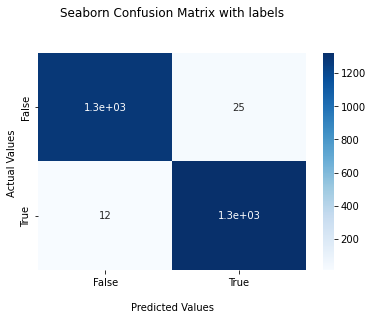

In [30]:
print("\nClassification Report \n")
print(classification_report(y_test,y_predict))
print("\nTest Confusion Matrix")
plot_confusion_matrix(cf_matrix)

### Summary

#### Model choice

In [31]:
df_summary

,Model,Training Accuracy,Accuracy,AUC,F1 Score,Miss Rate
0,SVM,0.999147,0.990144,0.99925,0.990327,0.0015
1,XGB,1.0,0.988249,0.998904,0.988463,0.003751
2,LOG,0.987964,0.985974,0.99865,0.986189,0.009002


As there is less overfit for same miss rate and a better AUC, we will chose the **SVM algorithm**

In [32]:
pickle.dump(best_svc, open("buffer\svm_model.pkl", "wb"))

#### Check on news data

In [33]:
w2v = pickle.load(open("buffer/word2vec.pkl", "rb"))

In [34]:
svm = pickle.load(open("buffer/svm_model.pkl", "rb"))

In [94]:
df_check = pd.read_csv(r"U:\dev\neg_news\src\data\20220310_news.csv").iloc[:,1:]

In [95]:
df_check['clean_text'] = df_check['text'].swifter.apply(lambda x: text_process(x))

Pandas Apply:   0%|          | 0/2461 [00:00<?, ?it/s]

In [96]:
df_check.head(3)

,text,clean_text
0,"He's tough on China, markets love him for now ...",tough china market love pledge shut ministry c...
1,Form 3 (initial statement of beneficial owners...,form initial statement beneficial ownership se...
2,Ifax Cites Russian Defence Ministry: Russian T...,ifax cite russian defence ministry russian tro...


In [102]:
X_check_tok= [nltk.word_tokenize(i) for i in df_check['clean_text']]  
X_check_vectors_w2v = w2v.transform(X_check_tok)
y_check_predict = svm.predict(X_check_vectors_w2v)

In [103]:
df_check["class"] = y_check_predict

In [104]:
df_check["class"] = np.where(df_check["class"]==1, "fraud", "normal")
df_check = df_check[df_check["class"]=="fraud"]